**此notebook是在transformer建模后回来写的。发现也许有很多可以优化的地方。所以重新写了一版。**



In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
import time
import numpy as np
import tensorflow as tf
from utils.preprocess import load_testcnn_data, load_tokenizer_binarizer
tf.__version__

'2.0.0'

# 训练

## 构建数据集

In [3]:
train_x, dev_x, test_x, train_y, dev_y, test_y = load_testcnn_data()
tokenizer, mlb = load_tokenizer_binarizer()
BUFFER_SIZE = 256
BATCH_SIZE = 256

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False)

# 流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。
# 没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 设定超参并建模

In [5]:
from textcnn.model import TextCNN

In [6]:
max_len = 128
vocab_size = 50000
embedding_dim=256
output_dim = len(train_y[0])  # 97
kernel_sizes = [2, 3, 4]
learning_rate = 0.01
epochs = 20
steps_per_epoch = len(train_x) // BATCH_SIZE

In [7]:
model = TextCNN(max_len=max_len, 
                vocab_size=vocab_size, 
                embedding_dim=embedding_dim, 
                output_dim=output_dim, 
                kernel_sizes=kernel_sizes)

## 损失函数、学习率 、评估指标、

In [8]:
# loss_object = tf.keras.losses.CategoricalCrossentropy()  # 多分类
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # 多标签分类
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [9]:
from utils.metrics import micro_f1, macro_f1, precision_recall
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='auto')

In [10]:
from textcnn.train import predict

In [11]:
train_step_signature = [
    tf.TensorSpec(shape=(None, 128), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(x, y):

    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_object(y, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, y_pred)
    
    return y_pred

loss_record = []
# 为了之后绘制曲线
dev_metrics = []
train_metrics = []

for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    train_y_true = []
    train_y_pred = []
    
    
    for batch, (x, y) in enumerate(train_dataset.take(steps_per_epoch)):
        y_pred = train_step(x, y)
        train_y_pred.append(y_pred)
        train_y_true.append(y)
        if batch % 20 == 0:
            print('epoch {} batch {:3d} loss {:.4f}'.format(
                epoch+1, batch+1, train_loss.result()))
            
    loss_record.append(train_loss.result().numpy())  # 记录下每轮loss的变化
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    
    dev_y_true = tf.cast(dev_y, tf.float32)
    dev_y_pred = predict(model, dev_x)
    
    train_y_true = tf.concat(train_y_true, axis=0)
    train_y_pred = tf.concat(train_y_pred, axis=0)
    
    dev_precision, dev_recall = precision_recall(dev_y_true, dev_y_pred)
    dev_micro_f1 = micro_f1(dev_y_true, dev_y_pred)
    dev_macro_f1 = macro_f1(dev_y_true, dev_y_pred)
    
    train_precision, train_recall = precision_recall(train_y_true, train_y_pred)
    train_micro_f1 = micro_f1(train_y_true, train_y_pred)
    train_macro_f1 = macro_f1(train_y_true, train_y_pred)
    
    dev_metrics.append([dev_precision.numpy(), dev_recall.numpy(), 
                        dev_micro_f1.numpy(), dev_macro_f1.numpy()])
    
    train_metrics.append([train_precision.numpy(), train_recall.numpy(), 
                          train_micro_f1.numpy(), train_macro_f1.numpy()])
    
    print('dev precision {:.4f} recall {:.4f} micro f1 {:.4f} macro f1 {:.4f}'.format(
            dev_precision, dev_recall, dev_micro_f1, dev_macro_f1))
    
    print('train precision {:.4f} recall {:.4f} micro f1 {:.4f} macro f1 {:.4f}'.format(
            train_precision, train_recall, train_micro_f1, train_macro_f1))
    
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))

epoch 1 batch   1 loss 0.6934
epoch 1 batch  21 loss 0.3934
epoch 1 batch  41 loss 0.2804
epoch 1 batch  61 loss 0.2338
Epoch 1 Loss 0.2139
dev precision 0.9452 recall 0.2699 micro f1 0.4199 macro f1 0.0736
train precision 0.5651 recall 0.0741 micro f1 0.1310 macro f1 0.0222
Time taken for 1 epoch 28.82 sec

epoch 2 batch   1 loss 0.1106
epoch 2 batch  21 loss 0.1004
epoch 2 batch  41 loss 0.0938
epoch 2 batch  61 loss 0.0881
Epoch 2 Loss 0.0851
dev precision 0.9242 recall 0.4538 micro f1 0.6087 macro f1 0.2023
train precision 0.9168 recall 0.3959 micro f1 0.5530 macro f1 0.1535
Time taken for 1 epoch 15.45 sec

epoch 3 batch   1 loss 0.0695
epoch 3 batch  21 loss 0.0647
epoch 3 batch  41 loss 0.0626
epoch 3 batch  61 loss 0.0601
Epoch 3 Loss 0.0587
dev precision 0.9195 recall 0.5800 micro f1 0.7113 macro f1 0.3861
train precision 0.9186 recall 0.5612 micro f1 0.6967 macro f1 0.3459
Time taken for 1 epoch 15.17 sec

epoch 4 batch   1 loss 0.0519
epoch 4 batch  21 loss 0.0498
epoch 4 ba

# 绘图

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# history = pd.read_csv('notebook/TextCNN/textcnn_report.csv')

In [14]:
history = pd.DataFrame(np.concatenate([dev_metrics, train_metrics], axis=1),
                        columns=['dev_precision', 'dev_recall', 'dev_micro_f1', 'dev_macro_f1',
                                 'train_precision', 'train_recall', 'train_micro_f1', 'train_macro_f1'])

In [15]:
history.index += 1
history

,dev_precision,dev_recall,dev_micro_f1,dev_macro_f1,train_precision,train_recall,train_micro_f1,train_macro_f1
1,0.945227,0.269884,0.419882,0.073618,0.565065,0.074078,0.130985,0.022173
2,0.924173,0.453828,0.608730,0.202321,0.916830,0.395929,0.553033,0.153496
3,0.919481,0.579982,0.711298,0.386105,0.918600,0.561158,0.696708,0.345911
4,0.905523,0.641446,0.750944,0.475594,0.926202,0.661085,0.771503,0.486635
5,0.886768,0.673419,0.765506,0.524257,0.931399,0.711757,0.806898,0.561037
6,0.884044,0.688512,0.774122,0.545305,0.934076,0.740728,0.826242,0.602710
7,0.876222,0.707477,0.782860,0.561537,0.938733,0.761744,0.841028,0.632858
8,0.885398,0.702314,0.783300,0.558598,0.937836,0.775506,0.848981,0.648726
9,0.880143,0.708371,0.784970,0.564982,0.940465,0.784135,0.855214,0.662649
10,0.866584,0.727832,0.791171,0.586411,0.944024,0.794585,0.862882,0.679444


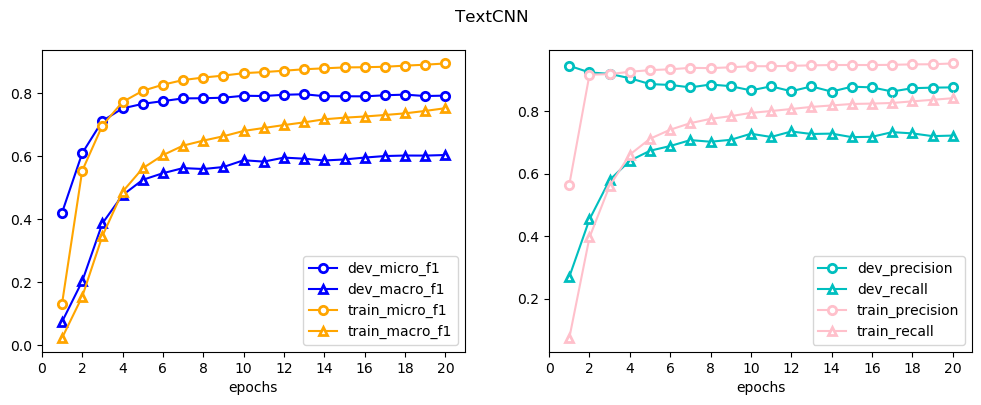

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),dpi=100)
ax[0].plot(history.dev_micro_f1, c='b', marker='o', mfc='w', mew=2, label='dev_micro_f1')
ax[0].plot(history.dev_macro_f1, c='b', marker='^', mfc='w', mew=2, label='dev_macro_f1')
ax[0].plot(history.train_micro_f1, c='orange', marker='o', mfc='w', mew=2, label='train_micro_f1')
ax[0].plot(history.train_macro_f1, c='orange', marker='^', mfc='w', mew=2, label='train_macro_f1')
ax[0].set_xlabel('epochs')
ax[0].legend()
ax[0].set_xticks(range(0, 21, 2))
ax[1].plot(history.dev_precision, c='c', marker='o', mfc='w', mew=2, label='dev_precision')
ax[1].plot(history.dev_recall, c='c', marker='^', mfc='w', mew=2, label='dev_recall')
ax[1].plot(history.train_precision, c='pink', marker='o', mfc='w', mew=2, label='train_precision')
ax[1].plot(history.train_recall, c='pink', marker='^', mfc='w', mew=2, label='train_recall')
ax[1].set_xlabel('epochs')
ax[1].legend()
ax[1].set_xticks(range(0, 21, 2))
fig.suptitle('TextCNN')
plt.show()

In [17]:
history.to_csv('notebook/TextCNN/textcnn_report.csv', index=None)

# 预测

In [18]:
# y_pred = np.load('notebook/TextCNN/test_y_pred.npy')
y_pred = predict(model, test_x)
test_micro_f1 = micro_f1(test_y, y_pred)
test_macro_f1 = macro_f1(test_y, y_pred)
test_precision, test_recall = precision_recall(test_y, y_pred)

In [20]:
np.save('notebook/TextCNN/test_y_pred.npy', y_pred)

In [19]:
print('test micro f1: {:.4f} macro f1: {:.4f}'.format(
    test_micro_f1, test_macro_f1))

print('test precision: {:.4f} recall: {:.4f}'.format(
    test_precision, test_recall))

test micro f1: 0.7834 macro f1: 0.5831
test precision: 0.8640 recall: 0.7166
